In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as PathEffects

from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

In [2]:
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [3]:
#Read the PSF size in the FORS2 images.
seeing_tab = Table.read("../../Resolved_Polarization_v3/All_seeing_values.txt", format='ascii')
seeing_tab.rename_column("col1", "WID")
seeing_tab.rename_column("col2", "Band")
seeing_tab.rename_column("col3", "FWHM")
seeing_tab.rename_column("col4", "filename")

In [4]:
seeing = dict()
seeing['FORS2'] = np.max(seeing_tab['FWHM'][seeing_tab['WID']=="W0204-0506"])*u.arcsec
seeing['F555W'] = 0.067*u.arcsec
seeing['F160W'] = 0.148*u.arcsec
print(seeing)

{'FORS2': <Quantity 0.86 arcsec>, 'F555W': <Quantity 0.067 arcsec>, 'F160W': <Quantity 0.148 arcsec>}


In [5]:
#We are blurring with a 1" Gaussian kernel the FORS2 observations. So we need to add this. 
seeing['FORS2'] = (seeing['FORS2']**2 + (1.0*u.arcsec)**2)**0.5

In [6]:
#Read all the images we will plot. 
pfrac = fits.open("../../Resolved_Polarization_v3/stamps_blurred_1.0/W0204-0506.R_SPECIAL.All.pfrac.fits")
pangle = fits.open("../../Resolved_Polarization_v3/stamps_blurred_1.0/W0204-0506.R_SPECIAL.All.pangle.fits")
stack = fits.open("../../Resolved_Polarization_v3/stamps_blurred_1.0/W0204-0506.R_SPECIAL.All.stack.fits")
fors2 = fits.open("../../HST/W0204/fors2.cutout.fits")
f160w = fits.open("../../HST/W0204/F160W.cutout.fits")
f555w = fits.open("../../HST/W0204/F555W.cutout.fits")

In [7]:
#Transform pfrac into percentage. 
pfrac[0].data *= 100

In [8]:
#Read the WCS from all the images that have one. 
fors2_wcs = WCS(fors2[0].header)
f160w_wcs = WCS(f160w[0].header)
f555w_wcs = WCS(f555w[0].header)

In [9]:
#All the cutouts have the same angular size and are aligned, but do not have the same pixel size. All the FORS2 cutouts do, however. We'll take the central pixel from the FORS2 data to set the coordinates references, and then we will do 5x5 arcsecond cutouts. 
px = (fors2[0].header['NAXIS1']-1)/2
py = (fors2[0].header['NAXIS2']-1)/2
f_center = fors2_wcs.pixel_to_world(px,py)

#Move the center 0.5" to the west. 
c_center = f_center.directional_offset_by(90*u.deg, -0.5*u.arcsec)

cutout_size = 22 * fors2_wcs.proj_plane_pixel_scales()[0]
size = (cutout_size, 1.15*cutout_size)
pfrac_co  = Cutout2D(pfrac[0].data , c_center, size=size, wcs=fors2_wcs)
pangle_co = Cutout2D(pangle[0].data, c_center, size=size, wcs=fors2_wcs)
stack_co  = Cutout2D(stack[0].data , c_center, size=size, wcs=fors2_wcs)
f160w_co  = Cutout2D(f160w[0].data , c_center, size=size, wcs=f160w_wcs)
f555w_co  = Cutout2D(f555w[0].data , c_center, size=size, wcs=f555w_wcs)

In [10]:
#We'll put a cross in the brightest pixel of the F160W image. 
max_pix = np.unravel_index(f160w_co.data.argmax(), f160w_co.data.shape)
max_coords = f160w_co.wcs.pixel_to_world(max_pix[1],max_pix[0])

/var/folders/p7/drxzchtj4yb641v79lt0tjyh0000gn/T/ipykernel_73725/1913402532.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


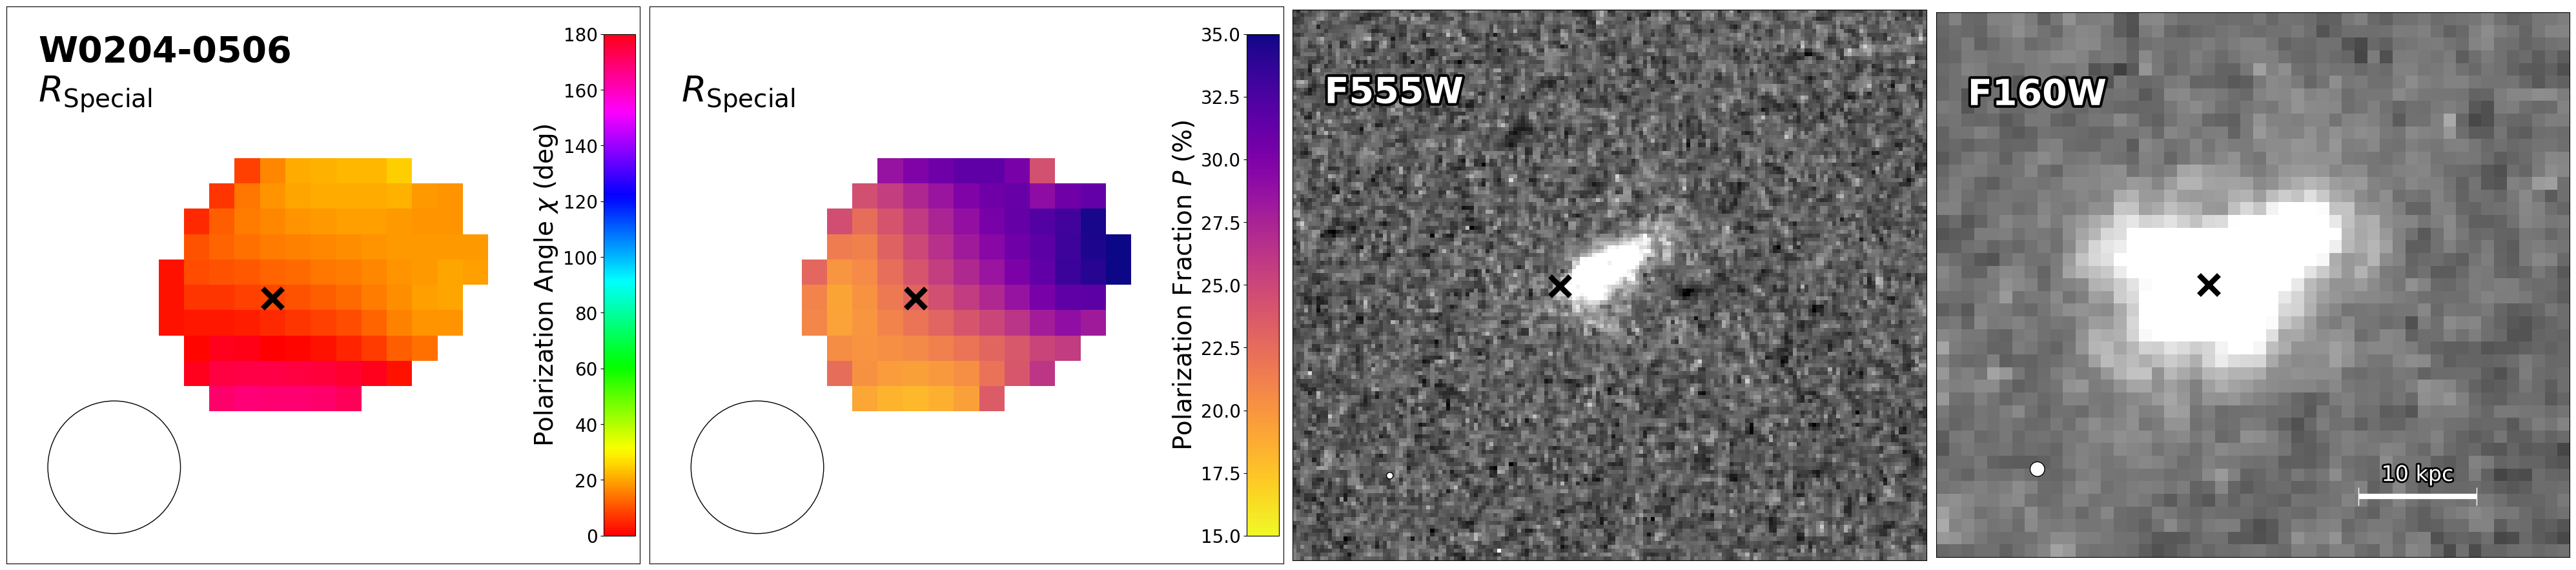

In [11]:
#Now, plot the panels. 
fig, axs = plt.subplots(1,4, figsize=(40,9), squeeze=False)
plt.subplots_adjust(wspace=0., hspace=0.)
for ax in axs.flat:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

_, _, rms = sigma_clipped_stats(stack[0].data, sigma=3.0)
mask = np.where(stack_co.data<5.0*rms, True, False)

pangle_co.data[mask] = np.nan
cm_pa = axs[0,0].imshow(pangle_co.data, vmin=0., vmax=180., cmap='hsv', origin='lower')
#cx, cy = pangle_co.wcs.world_to_pixel(f_center)
cx, cy = pangle_co.wcs.world_to_pixel(max_coords)
axs[0,0].scatter([cx], [cy], color='black', marker='x', s=500, lw=6.0)
cax = inset_axes(axs[0,0], width="5%", height="90%", loc='center right') 
cbar = fig.colorbar(cm_pa, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label=r'Polarization Angle $\chi~(\rm deg)$', fontsize=28)
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')

pfrac_co.data[mask] = np.nan
cm_pf = axs[0,1].imshow(pfrac_co.data, vmin=15., vmax=35., cmap='plasma_r', origin='lower')
#cx, cy = pangle_co.wcs.world_to_pixel(f_center)
cx, cy = pangle_co.wcs.world_to_pixel(max_coords)
axs[0,1].scatter([cx], [cy], color='black', marker='x', s=500, lw=6.0)
cax = inset_axes(axs[0,1], width="5%", height="90%", loc='center right') 
cbar = fig.colorbar(cm_pf, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label=r'Polarization Fraction $P~(\%)$', fontsize=28)
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')

norm_f555w = ImageNormalize(f555w_co.data, stretch=LinearStretch(), interval=ZScaleInterval())
axs[0,2].imshow(f555w_co.data, norm=norm_f555w, cmap='gray', origin='lower')
#cx, cy = f555w_co.wcs.world_to_pixel(f_center)
cx, cy = f555w_co.wcs.world_to_pixel(max_coords)
axs[0,2].scatter([cx], [cy], color='black', marker='x', s=500, lw=6.0)

norm_f160w = ImageNormalize(f160w_co.data, stretch=LinearStretch(), interval=ZScaleInterval(), vmin=-0.20)
axs[0,3].imshow(f160w_co.data, norm=norm_f160w, cmap='gray', origin='lower')
#cx, cy = f160w_co.wcs.world_to_pixel(f_center)
cx, cy = f160w_co.wcs.world_to_pixel(max_coords)
axs[0,3].scatter([cx], [cy], color='black', marker='x', s=500, lw=6.0)

#Object label
axs[0,0].text(0.05, 0.9, "W0204-0506", transform=axs[0,0].transAxes, fontsize=40, weight='bold')
axs[0,0].text(0.05, 0.83, r'$R_{\rm Special}$', transform=axs[0,0].transAxes, fontsize=40, weight='bold')

txt = axs[0,1].text(0.05, 0.83, r'$R_{\rm Special}$', transform=axs[0,1].transAxes, fontsize=40, weight='bold')

txt = axs[0,2].text(0.05, 0.83, r'F555W', transform=axs[0,2].transAxes, fontsize=40, weight='bold', color='white')
txt.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='black')])

txt = axs[0,3].text(0.05, 0.83, r'F160W', transform=axs[0,3].transAxes, fontsize=40, weight='bold', color='white')
txt.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='black')])

#Beam size
for k, inst in enumerate(['FORS2','FORS2','F555W','F160W']):
    if inst=='FORS2':
        im = stack_co
    elif inst=='F555W':
        im = f555w_co
    elif inst=='F160W':
        im = f160w_co
    ny, nx = im.data.shape
    pixscale = im.wcs.proj_plane_pixel_scales()[0]
    beam  = plt.Circle((nx*0.15,ny*0.15),(seeing[inst]/2/pixscale).to(u.dimensionless_unscaled), color='k', fill=True, fc='white')
    axs[0,k].add_patch(beam)


#10kpc bar
pixscale = f160w_co.wcs.proj_plane_pixel_scales()[0]
bar_size = (10*u.kpc/cosmo.angular_diameter_distance(2.100))*u.rad
bar_size_pix = (bar_size / pixscale).to(u.dimensionless_unscaled)
ny, nx = f160w_co.data.shape
axs[0,3].errorbar([0.75*nx],[0.1*ny],xerr=[bar_size_pix/2.], fmt='none', capsize=10.0,lw=6.0,color='white')
txt = axs[0,3].text(0.75*nx,0.12*ny,"10 kpc",ha='center',va='bottom', fontsize=24, color='white')
txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='black')])

plt.tight_layout()
plt.show()

fig.savefig("W0204_pol_HST.blurred_1.0.png", dpi=200)